In [1]:
# third party
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import scipy
from sklearn.preprocessing import StandardScaler
import torch

In [2]:
# Filenames and directories
MODULE_DIR = "other_prediction_functions"
INPUT_SQ_DIR = "a. Input time series sequences"
# same as in Matlab repo, could be improved later: load from json and remove RNN
VAR_OUT_DIR = "models"

# if True, use ETH data as training set and Magdeburg data as test set, otherwise that's the contrary
USE_ETH_DATA_AS_TRAINING = False

# if true, hyperparameter tuning is done, after which the configuration is updated before evaluation of the test set
HYPERPARAMETER_TUNING = True

horizon = 1
n_models = 10
num_epochs = 300
learning_rate = 0.0001
early_stop_patience = 30  # 20
print_every = 10
init_seed = 42  # the seed of the first model to train
selected_device = "cuda"  # choose between "cuda" or "cpu"

# Model parameters
d_model = 16  # Embedding dimension
nhead = 2  # Number of heads in multi-head attention
num_layers = 2  # Number of transformer layers
dim_feedforward = 16  # Dimension of feedforward network
dropout = 0.5  # Dropout rate (now explicit)
final_layer_dim = None  # Dimension of the final hidden linear layer, None sets it to geometric mean of input and output

# Hyperparameters
seq_length = 24  # Input sequence length
training_fraction = 0.8  # Fraction of data used for training
batch_size = 32

# Parameters we use for data augmentaiton
scaling_range = (0.8, 1.2)  # Random amplitude scaling
permutation_prob = 0.5  # Probability of dimension permutation
drift_prob = 0.3  # Probability of adding baseline drift
max_drift_factor = 0.05  # Maximum drift (as fraction of signal amplitude)
bias_prob = 0.3  # Probability of adding baseline bias
max_bias_factor = 0.2  # Maximum bias (as fraction of signal amplitude

# Index of the model we want to test and for which we plot predictions - cf test section of the notebook
test_model_idx = 0

# Index of the sequence in the test set we use as an example for testing - cf test section of the notebook
test_sequence_idx = 0

In [3]:
folders = {
    "dev_folders": [
        "2. sq sl010 sag Xcs=125 3 cpts 2024 normalised",
        "3. sq sl010 sag Xcs=80 3 cpts 2024 normalised",
        "4. sq sl014 sag Xcs=165 3 cpts 2024 normalised",
        "5. sq sl014 sag Xcs=95 3 cpts 2024 normalised",
    ],
    "test_folders": [
        "2020-11-10_KS81_Nav_Pur_1_3_cpts",
        "2020-11-12_QN76_Nav_Pur_1_3_cpts",
        "2020-11-17_CS31_Nav_Pur_2_3_cpts",
        "2020-11-17_JY02_Nav_Pur_2_3_cpts",
        "2020-11-23_ON65_Nav_Pur_2_3_cpts",
        "2020-11-23_PS11_Nav_Pur_1_3_cpts",
        "2020-11-25_II29_Nav_Pur_1_3_cpts",
        "2020-11-26_NE38_Nav_Pur_1_3_cpts",
    ],
}

# Resampling parameters
dev_freq_hz = 3.18  # eth dataset sampling frequency
test_freq_hz = 6.0  # magdeburg dataset sampling frequency

if USE_ETH_DATA_AS_TRAINING:
    adaptation_window = 160  # corresponds to pred_par.tmax_training for the Magdeburg dataset (here used as test set)
    dataset_out_dirname = "training_with_eth_dataset"
else:
    folders["dev_folders"], folders["test_folders"] = folders["test_folders"], folders["dev_folders"]
    dev_freq_hz, test_freq_hz = test_freq_hz, dev_freq_hz
    adaptation_window = 303  # corresponds to pred_par.tmax_training for the ETH dataset (here used as test set)
    dataset_out_dirname = "training_with_magdeburg_dataset"

In [4]:
import sys
import os

# Get the current notebook's directory
notebook_dir = os.getcwd()

# Construct the relative path to the module
module_dir = os.path.join(notebook_dir, "..", MODULE_DIR)

# Add to sys.path if not already included
if module_dir not in sys.path:
    sys.path.append(module_dir)

# Importing the module for transformer forecasting
import transformers_forecasting as tf  # type: ignore

/home/michel/miniconda3/envs/future_frame_prediction_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading the data


In [5]:
# Loading data
workspace_dir = os.path.dirname(notebook_dir)
for folder_type, folders_list in folders.items():
    folders[folder_type] = [os.path.join(workspace_dir, INPUT_SQ_DIR, folder) for folder in folders_list]

raw_data, n_features = tf.load_dev_test_data(**folders)

Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-10_KS81_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-12_QN76_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_CS31_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-17_JY02_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_ON65_Nav_Pur_2_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-23_PS11_Nav_Pur_1_3_cpts...
Loading development data from /mnt/d/MRI_prediction/Time_series_forecasting/a. Input time series sequences/2020-11-25_II29_Nav_Pur_1_3_cpts...

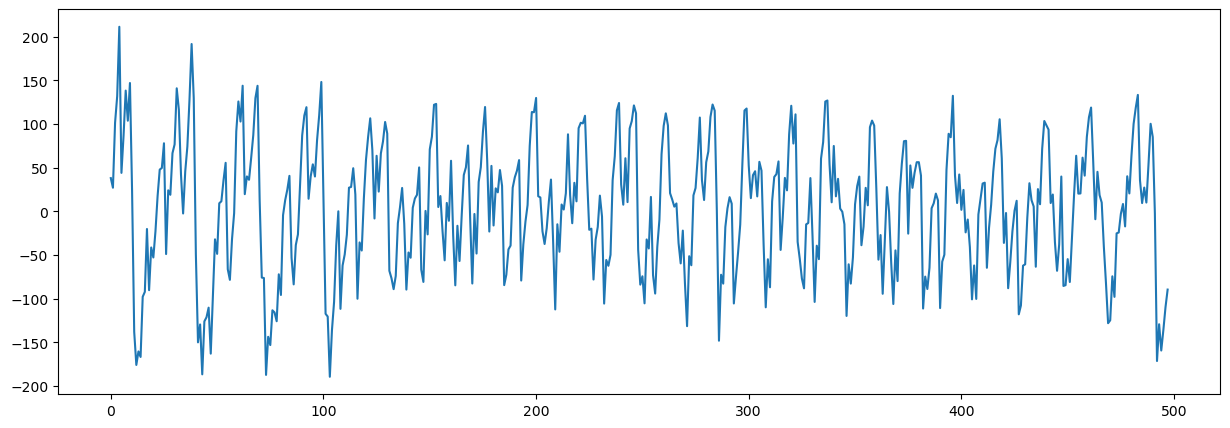

In [6]:
# plotting the original data - modify the sequence index and coordinate you want to plot
sequence_idx = 0
crd_idx = 1

plt.figure(figsize=(15, 5))
plt.plot(raw_data["dev_data"][sequence_idx][crd_idx].T)
plt.show()

Resampling the data


In [7]:
# Resample data if frequencies differ
if dev_freq_hz != test_freq_hz:
    resampled_dev_data = tf.resample_data_poly(raw_data["dev_data"], dev_freq_hz, test_freq_hz)

resampled_data = raw_data.copy()
resampled_data["dev_data"] = resampled_dev_data

Resampling with ratio 6.0/3.18 = 100/53
Resampled dev signal 1: 498 → 264 samples (expected ~263)
Resampled dev signal 2: 498 → 264 samples (expected ~263)
Resampled dev signal 3: 498 → 264 samples (expected ~263)
Resampled dev signal 4: 498 → 264 samples (expected ~263)
Resampled dev signal 5: 498 → 264 samples (expected ~263)
Resampled dev signal 6: 498 → 264 samples (expected ~263)
Resampled dev signal 7: 498 → 264 samples (expected ~263)
Resampled dev signal 8: 498 → 264 samples (expected ~263)


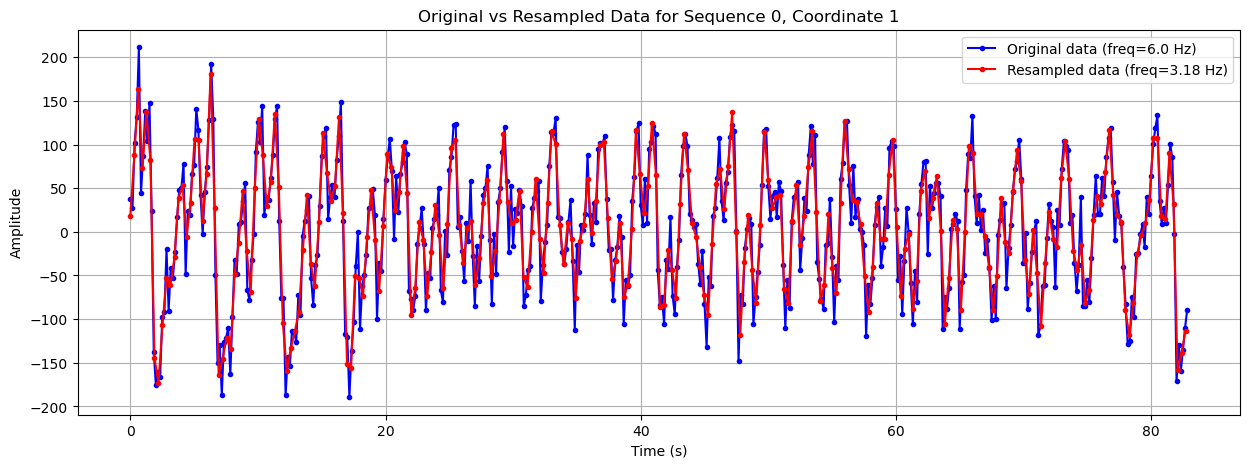

In [8]:
# plotting the original against the resampled data to check that resampling worked
org_sq = raw_data["dev_data"][sequence_idx][crd_idx].T
resampled_sq = resampled_dev_data[sequence_idx][crd_idx].T

# plot inspired by https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample_poly.html
t = np.linspace(0, (1 / dev_freq_hz) * org_sq.shape[0], org_sq.shape[0], endpoint=False)
t_new = np.linspace(0, (1 / test_freq_hz) * resampled_sq.shape[0], resampled_sq.shape[0], endpoint=False)

plt.figure(figsize=(15, 5))
plt.plot(
    t,
    raw_data["dev_data"][sequence_idx][crd_idx].T,
    "b.-",
    label=f"Original data (freq={dev_freq_hz} Hz)",
)
plt.plot(t_new, resampled_dev_data[sequence_idx][crd_idx].T, "r.-", label=f"Resampled data (freq={test_freq_hz} Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title(f"Original vs Resampled Data for Sequence {sequence_idx}, Coordinate {crd_idx}")
plt.legend()
plt.grid()
plt.show()

In [9]:
# Preprocessing data and splitting the data into pairs of unput and target values
standardized_data, scaler = tf.preprocess_data(resampled_data, horizon, seq_length, training_fraction)

# Getting pytorch data loaders
data_loaders = tf.get_population_data_loaders(standardized_data, batch_size=batch_size)

train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
train set: Added 187 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
val set: Added 29 sequences
test set: Added 176 sequences
test set: Added 176 sequences
test set: Added 176 sequences
test set: Added 176 sequences
Train loader: 1496 sequences
Val loader: 232 sequences
Test loader: 704 sequences


/tmp/ipykernel_173780/3168231899.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  plt.plot(train_batch_inputs[idx_in_batch, :, feature_idx].T, "b.-", label="Original")


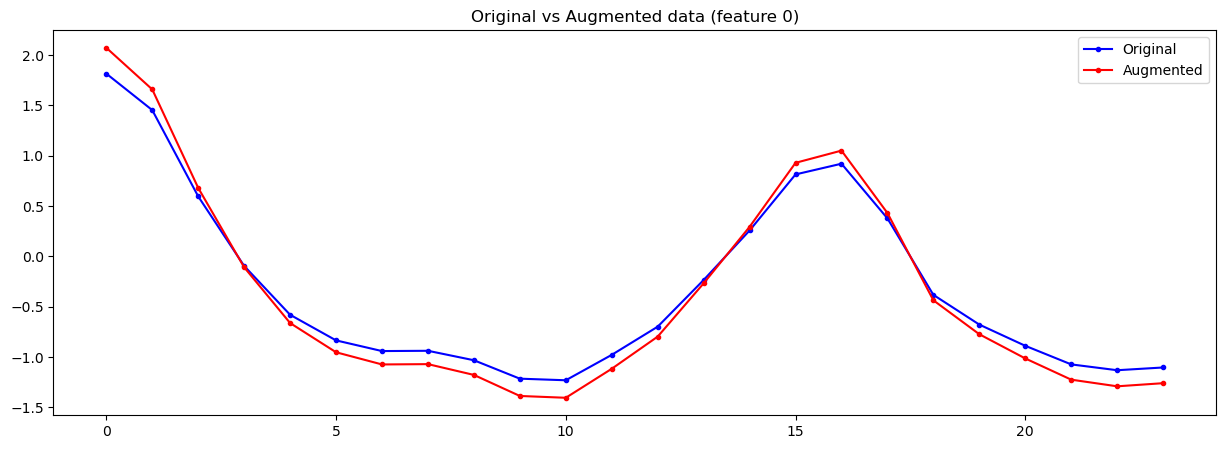

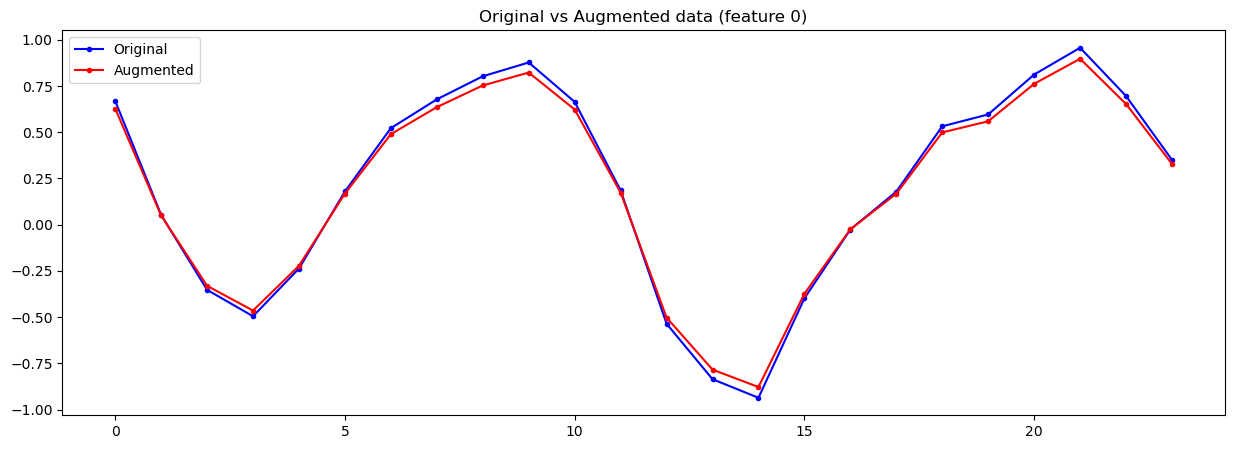

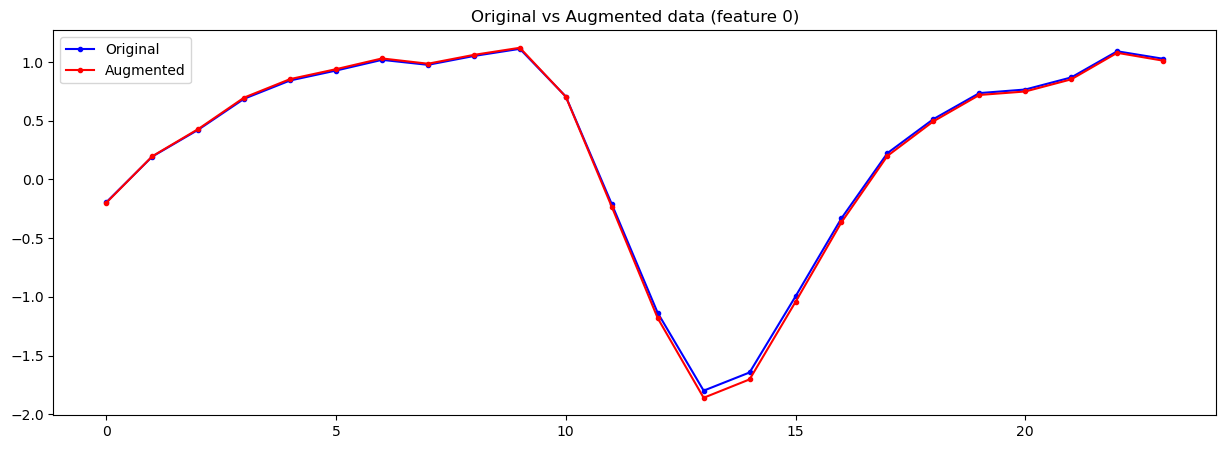

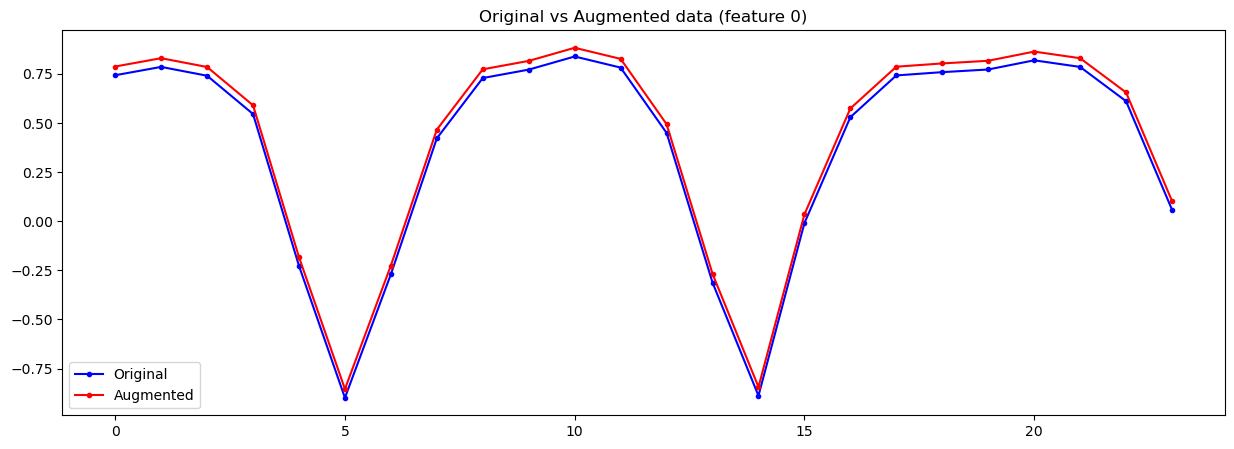

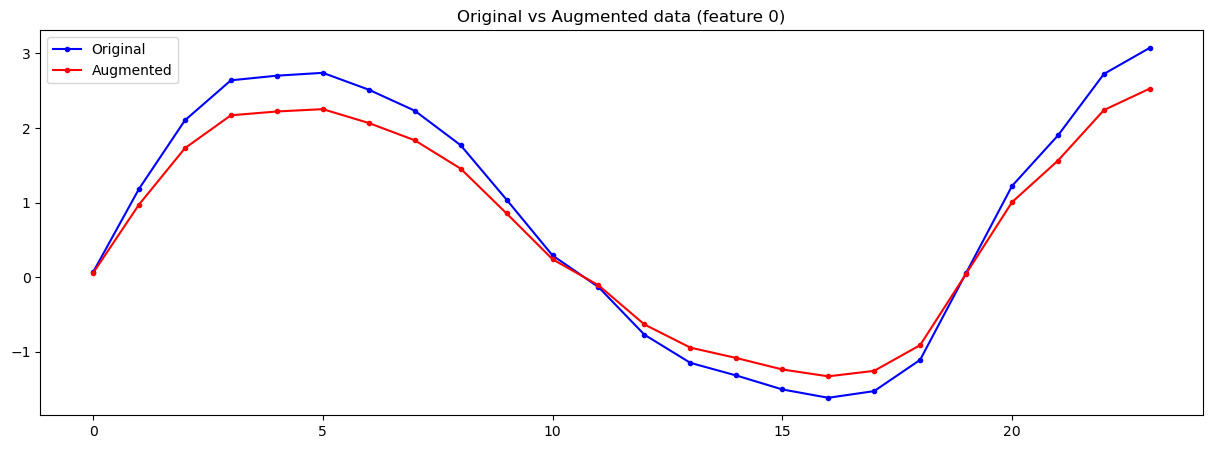

In [10]:
# Rerun the cell several times to get different batches and targets
# Trying to plot augmentation of the data - as a demonstration

# Parameters to play with by hand
tmp_config = {
    "scaling_range": (0.8, 1.2),  # Random amplitude scaling
    "permutation_prob": 0.0,  # Probability of dimension permutation
    "drift_prob": 0.3,  # Probability of adding baseline drift
    "max_drift_factor": 0.05,  # Maximum drift (as fraction of signal amplitude)
    "bias_prob": 0.3,  # Probability of adding baseline bias
    "max_bias_factor": 0.2,  # Maximum bias (as fraction of signal amplitude
}
nb_plts = 5
feature_idx = 0

for _ in range(nb_plts):
    train_batch_inputs, train_batch_targets = next(iter(data_loaders["train"]))

    # Doing the augmentation
    augmented_batch_inputs, augmented_batch_targets = tf.time_series_augmentation_suite(
        train_batch_inputs, train_batch_targets, config=tmp_config
    )
    idx_in_batch = 0

    # Plotting the original and augmented data
    plt.figure(figsize=(15, 5))
    plt.plot(train_batch_inputs[idx_in_batch, :, feature_idx].T, "b.-", label="Original")
    plt.plot(augmented_batch_inputs[idx_in_batch, :, feature_idx].T, "r.-", label="Augmented")
    plt.legend()
    plt.title(f"Original vs Augmented data (feature {feature_idx})")


plt.show()

Training multiple models ("n_runs") to account for stochasticity


In [13]:
# creating model output director if not already present
model_output_dir = os.path.join(workspace_dir, VAR_OUT_DIR, dataset_out_dirname)
Path(model_output_dir).mkdir(parents=True, exist_ok=True)

# Get the device
device = tf.get_device(selected_device)
print(f"Using device: {device}")

# Setting up the config dictionary, containing variables for initializing the transformer
config = {
    "horizon": horizon,  # Prediction horizon
    "n_features": n_features,
    "output_dim": n_features,
    "seq_length": seq_length,
    "d_model": d_model,
    "nhead": nhead,
    "num_layers": num_layers,
    "dim_feedforward": dim_feedforward,
    "dropout": dropout,
    "final_layer_dim": final_layer_dim,
    "seed": init_seed,
    "batch_size": batch_size,  # for logging in Matlab (e.g., in fprintfpred_par.m)
    "learning_rate": learning_rate,  # same
    "early_stop_patience": early_stop_patience,  # same
    "training_fraction": training_fraction,  # same
    "num_epochs": num_epochs,  # same
    "nb_runs": n_models,  # Number of models to train, for inference in Matlab
    "SHL": seq_length,  # signal history length, for inference in Matlab
    "scaling_range": scaling_range,  # Random amplitude scaling
    "permutation_prob": permutation_prob,  # Probability of dimension permutation
    "drift_prob": drift_prob,  # Probability of adding baseline drift
    "max_drift_factor": max_drift_factor,  # Maximum drift (as fraction of signal amplitude)
    "bias_prob": bias_prob,  # Probability of adding baseline bias
    "max_bias_factor": max_bias_factor,  # Maximum bias (as fraction of signal amplitude
    "print_every": print_every,  # Print every n epochs
}

Using device: cuda


In [ ]:
# If we use the ETH dataset for training, it will be resampled to the same frequency as the Magdeburg dataset
# and the sequence length will be adapted to the Magdeburg dataset, otherwise the opposite is true.
param_grid = {
    "seq_length": [11, 23, 34, 45, 57] if USE_ETH_DATA_AS_TRAINING else [6, 12, 18, 24, 30],
    "learning_rate": [1e-4, 5e-4],
    "num_layers": [1, 2],
    "d_model": [8, 16],
}

if HYPERPARAMETER_TUNING:
    # replacing some values just for faster testing - uncomment if needed
    # param_grid = {"seq_length": [11, 23, 34, 45, 57] if USE_ETH_DATA_AS_TRAINING else [6, 12, 18, 24, 30]}
    # config["nb_runs"] = 2
    # config["num_epochs"] = 30

    best_params = tf.hyperparameter_tuning(
        config,
        param_grid,
        resampled_data,
        device,
        n_jobs=-1,
        n_trials=config.get("n_trials", None),
        pruner=None,  # we don't use pruning here, but you can set it to optuna.pruners.MedianPruner() or similar
        study_name=config.get("study_name", "transformer_optimization"),
        save_dir=config.get("save_dir", "tmp"),
    )
    print(f"Best parameters: {best_params}")

    # Rk: I do not run grid search over the batch size or training fraction, but that may be accounted for below
    if config["seq_length"] != best_params.get("seq_length", config["seq_length"]):
        print(f"Updating sequence length from {config['seq_length']} to {best_params['seq_length']}")
        seq_length = best_params["seq_length"]  # just in case I reuse that variable later in the notebook
        standardized_data, scaler = tf.preprocess_data(resampled_data, horizon, seq_length, training_fraction)
        data_loaders = tf.get_population_data_loaders(standardized_data, batch_size)

    # Update the config with the best parameters found
    config.update(best_params)

[I 2025-06-08 22:10:10,119] A new study created in memory with name: transformer_optimization


Setting n_trials=5 to match grid size
Generating sequences with length 18...
Generating sequences with length 6...
Generating sequences with length 12...
Generating sequences with length 24...
Generating sequences with length 30...
train set: Added 205 sequences
train set: Added 187 sequences
train set: Added 181 sequences
train set: Added 193 sequences
train set: Added 199 sequences
train set: Added 205 sequences
train set: Added 187 sequences
train set: Added 193 sequences
train set: Added 181 sequences
train set: Added 199 sequences
train set: Added 205 sequences
train set: Added 193 sequences
train set: Added 181 sequences
train set: Added 187 sequences
train set: Added 199 sequences
train set: Added 193 sequences
train set: Added 205 sequences
train set: Added 187 sequences
train set: Added 181 sequences
train set: Added 193 sequences
train set: Added 199 sequences
train set: Added 205 sequences
train set: Added 187 sequences
train set: Added 181 sequences
train set: Added 193 seq

[I 2025-06-08 22:11:50,856] Trial 1 finished with value: 0.3912180482099453 and parameters: {'seq_length': 6}. Best is trial 1 with value: 0.3912180482099453.


Test Loss for Model 2: 6.0345
Epoch [20/30], Train Loss: 0.4177, Val Loss: 0.5547
Epoch [30/30], Train Loss: 0.3817, Val Loss: 0.3943
Test Loss for Model 1: 6.1062

Training model 2/2 for horizon=1
Epoch [10/30], Train Loss: 0.7199, Val Loss: 0.6849
Epoch [30/30], Train Loss: 0.3490, Val Loss: 0.4876


[I 2025-06-08 22:12:04,860] Trial 4 finished with value: 0.4868463985621929 and parameters: {'seq_length': 30}. Best is trial 1 with value: 0.3912180482099453.


Test Loss for Model 2: 6.3743
Epoch [20/30], Train Loss: 0.4142, Val Loss: 0.5306
Epoch [10/30], Train Loss: 0.6140, Val Loss: 0.5934
Epoch [30/30], Train Loss: 0.3645, Val Loss: 0.4910
Test Loss for Model 1: 6.2529

Training model 2/2 for horizon=1
Epoch [20/30], Train Loss: 0.5075, Val Loss: 0.5437
Epoch [20/30], Train Loss: 0.4487, Val Loss: 0.4752
Epoch [10/30], Train Loss: 0.5664, Val Loss: 0.6899
Epoch [20/30], Train Loss: 0.4217, Val Loss: 0.5658
Epoch [30/30], Train Loss: 0.4334, Val Loss: 0.4691
Test Loss for Model 1: 6.1929

Training model 2/2 for horizon=1


[I 2025-06-08 22:12:41,701] Trial 0 finished with value: 0.40991853591468597 and parameters: {'seq_length': 18}. Best is trial 1 with value: 0.3912180482099453.


Epoch [30/30], Train Loss: 0.3771, Val Loss: 0.4255
Test Loss for Model 2: 6.1376


[I 2025-06-08 22:12:47,602] Trial 3 finished with value: 0.5089314412325621 and parameters: {'seq_length': 24}. Best is trial 1 with value: 0.3912180482099453.


Epoch [30/30], Train Loss: 0.3624, Val Loss: 0.5268
Test Loss for Model 2: 6.3071
Epoch [10/30], Train Loss: 0.6277, Val Loss: 0.6170
Epoch [20/30], Train Loss: 0.4560, Val Loss: 0.4966


[I 2025-06-08 22:12:58,192] Trial 2 finished with value: 0.4578021365133199 and parameters: {'seq_length': 12}. Best is trial 1 with value: 0.3912180482099453.


Epoch [30/30], Train Loss: 0.3880, Val Loss: 0.4465
Test Loss for Model 2: 6.1083
Best trial: 1
Best value: 0.3912180482099453
Best hyperparameters:
    seq_length: 6
Study results saved to tmp/optuna_results_20250608_221258.json
Best parameters: {'seq_length': 6}
Updating sequence length from 24 to 6
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
train set: Added 205 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
val set: Added 47 sequences
test set: Added 194 sequences
test set: Added 194 sequences
test set: Added 194 sequences
test set: Added 194 sequences
Train loader: 1640 sequences
Val loader: 376 sequences
Test loader: 776 sequences


In [15]:
# Train the models with the best parameters found or the original config if tuning was not performed
horizon_results = tf.train_multiple_models(
    config, device, data_loaders, early_stop_patience, save_dir=model_output_dir, print_every=print_every
)


Training model 1/2 for horizon=1
Epoch [10/30], Train Loss: 0.7895, Val Loss: 0.6319
Epoch [20/30], Train Loss: 0.5963, Val Loss: 0.4953
Epoch [30/30], Train Loss: 0.5046, Val Loss: 0.4145
Test Loss for Model 1: 5.9966
Model 1 saved to /mnt/d/MRI_prediction/Time_series_forecasting/models/training_with_magdeburg_dataset/horizon_1/transformer_h1_model1_20250608_221505.pt

Training model 2/2 for horizon=1
Epoch [10/30], Train Loss: 0.7689, Val Loss: 0.5994
Epoch [20/30], Train Loss: 0.5620, Val Loss: 0.4475
Epoch [30/30], Train Loss: 0.4602, Val Loss: 0.3975
Test Loss for Model 2: 6.0279
Model 2 saved to /mnt/d/MRI_prediction/Time_series_forecasting/models/training_with_magdeburg_dataset/horizon_1/transformer_h1_model2_20250608_221517.pt


Try to show average loss with confidence intervals for each model rather than 10 graphs


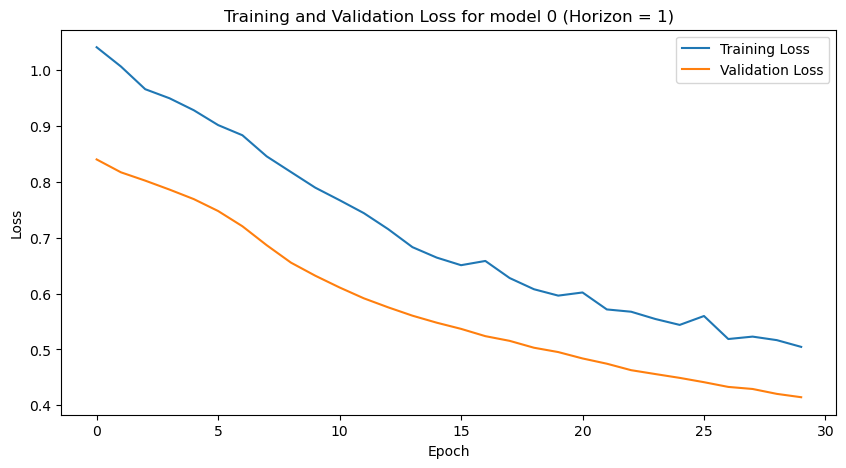

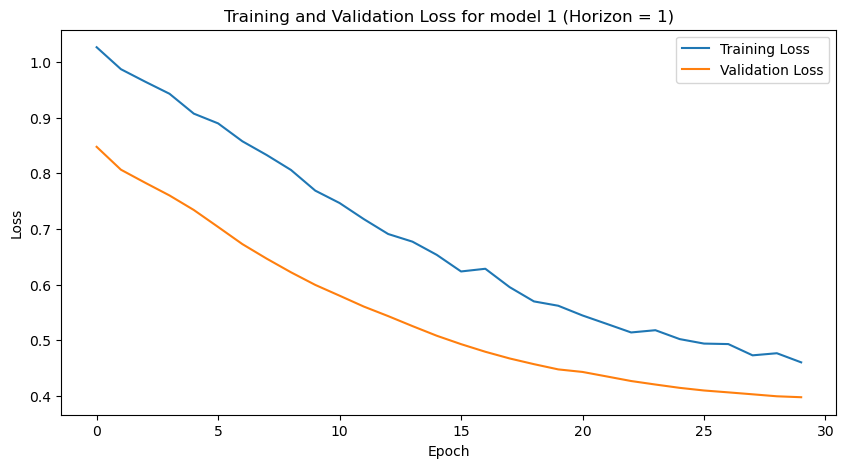

In [16]:
# Plot training and validation losses
for model_idx in range(config["nb_runs"]):  # n_models
    plt.figure(figsize=(10, 5))
    plt.plot(horizon_results[model_idx]["training_history"]["train_losses"], label="Training Loss")
    plt.plot(horizon_results[model_idx]["training_history"]["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training and Validation Loss for model {model_idx} (Horizon = {horizon})")
    plt.legend()
    plt.show()

Evaluation on a particular test sequence


In [17]:
# Loading the specified model for prediction
model = tf.init_model(config)
model.load_state_dict(torch.load(horizon_results[test_model_idx]["model_path"], map_location=device))

# To avoid the error: Expected all tensors to be on the same device, but found at least two devices
model.to(device)

input_sq_name = folders["test_folders"][test_sequence_idx].split("/")[-1]
print(f"Using data from {input_sq_name} for testing")

# I need to recreate the loader for the test data because data_loaders["test"] contains the test data for all the test
# sequences concatenated - one just need to try:
# test_predictions, test_targets, _ = tf.eval_model(model, data_loaders["test"], device)
# print(f"test_predictions shape: {test_predictions.shape}")
# print(f"test_targets shape: {test_targets.shape}")

# # First option: starting from scratch
# sq_filename = os.path.join(workspace_dir, INPUT_SQ_DIR, input_sq_name, tf.DATA_FILENAME)
# time_data_mat = scipy.io.loadmat(sq_filename)
# test_signals = time_data_mat["org_data"]
# n_samples_test = test_signals.shape[1]
# test_data_scaled = scaler.transform(test_signals.T)
# X_test, y_test, test_indices = tf.create_multidim_sequences(test_data_scaled.T, config["seq_length"], horizon)

# Second option (shorter): using the standardized_data that I computed previously:
test_data_scaled = standardized_data["test"][test_sequence_idx]
X_test, y_test, test_indices = test_data_scaled["X"], test_data_scaled["y"], test_data_scaled["indices"]

test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)
test_predictions, test_targets, _ = tf.eval_model(model, test_loader, device)
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets)

Using data from 2. sq sl010 sag Xcs=125 3 cpts 2024 normalised for testing
test_predictions shape: (194, 3)
test_targets shape: (194, 3)


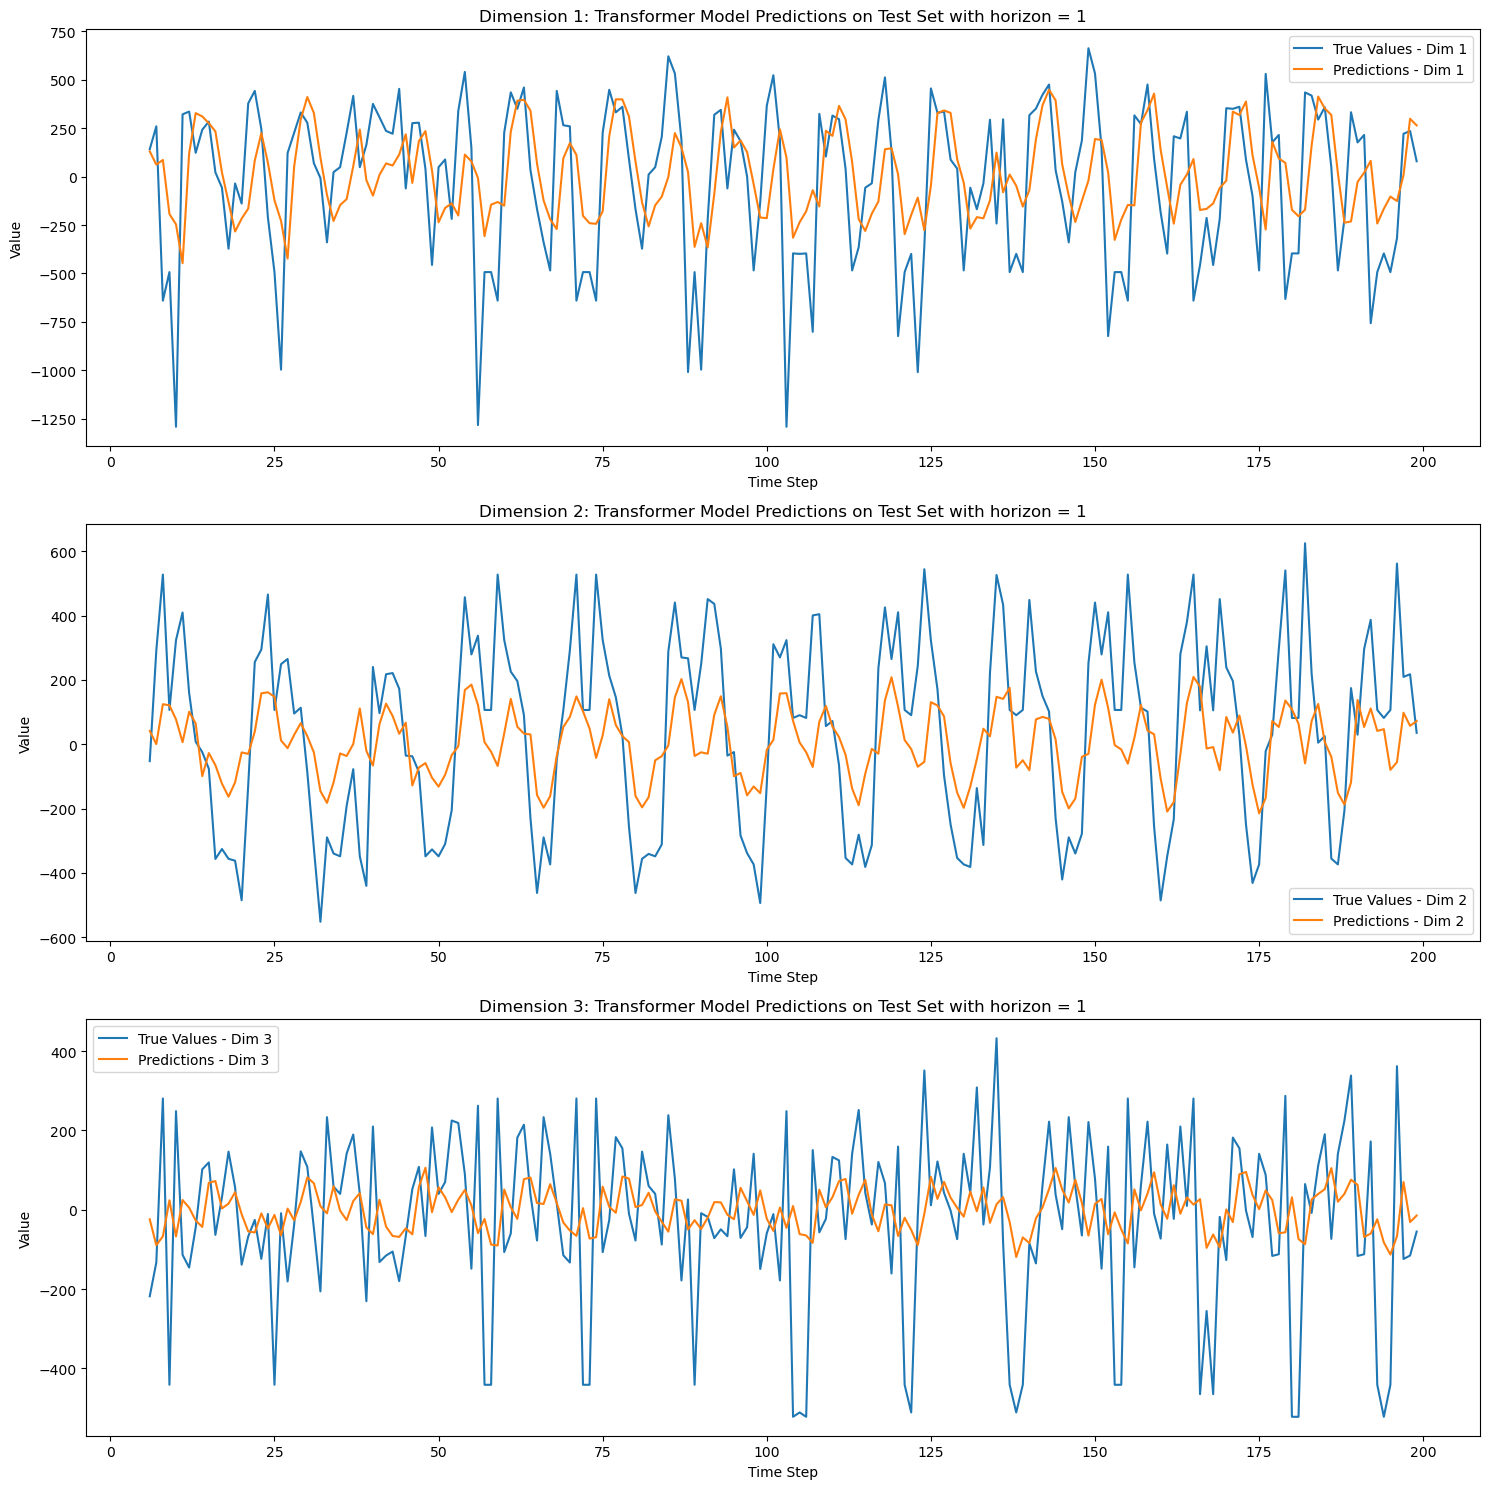

In [18]:
# Plot test predictions for each dimension
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)  # not the same as in Matlab / the paper
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 1:
Test MSE: 84514.4297, RMSE: 290.7137, MAE: 222.6928


Redoing the prediction, but this time with adaptive scaling - to help cope with low variations in training data and
potential distribution gap between training and testing...


In [20]:
# I need to load my input sequence from scratch
sq_filename = os.path.join(workspace_dir, INPUT_SQ_DIR, input_sq_name, tf.DATA_FILENAME)
time_data_mat = scipy.io.loadmat(sq_filename)
test_sequence = time_data_mat["org_data"]

adaptive_test_scaler = StandardScaler()  # here it is adaptive in the sense that it is fitted using the first datapoints
adaptation_data = test_sequence[:, :adaptation_window]
adaptive_test_scaler.fit(adaptation_data.T)
test_sequence_scaled = adaptive_test_scaler.transform(test_sequence.T)

X_test, y_test, test_indices = tf.create_multidim_sequences(test_sequence_scaled.T, seq_length, horizon)

In [21]:
# then it's the same code as above - probably refactor that

test_loader = tf.get_data_loader(X_test, y_test, batch_size, shuffle=False)
test_predictions, test_targets, _ = tf.eval_model(model, test_loader, device)
print(f"test_predictions shape: {test_predictions.shape}")
print(f"test_targets shape: {test_targets.shape}")

# Inverse standardization
test_predictions_rescaled = adaptive_test_scaler.inverse_transform(test_predictions)
test_targets_rescaled = adaptive_test_scaler.inverse_transform(test_targets)

test_predictions shape: (194, 3)
test_targets shape: (194, 3)


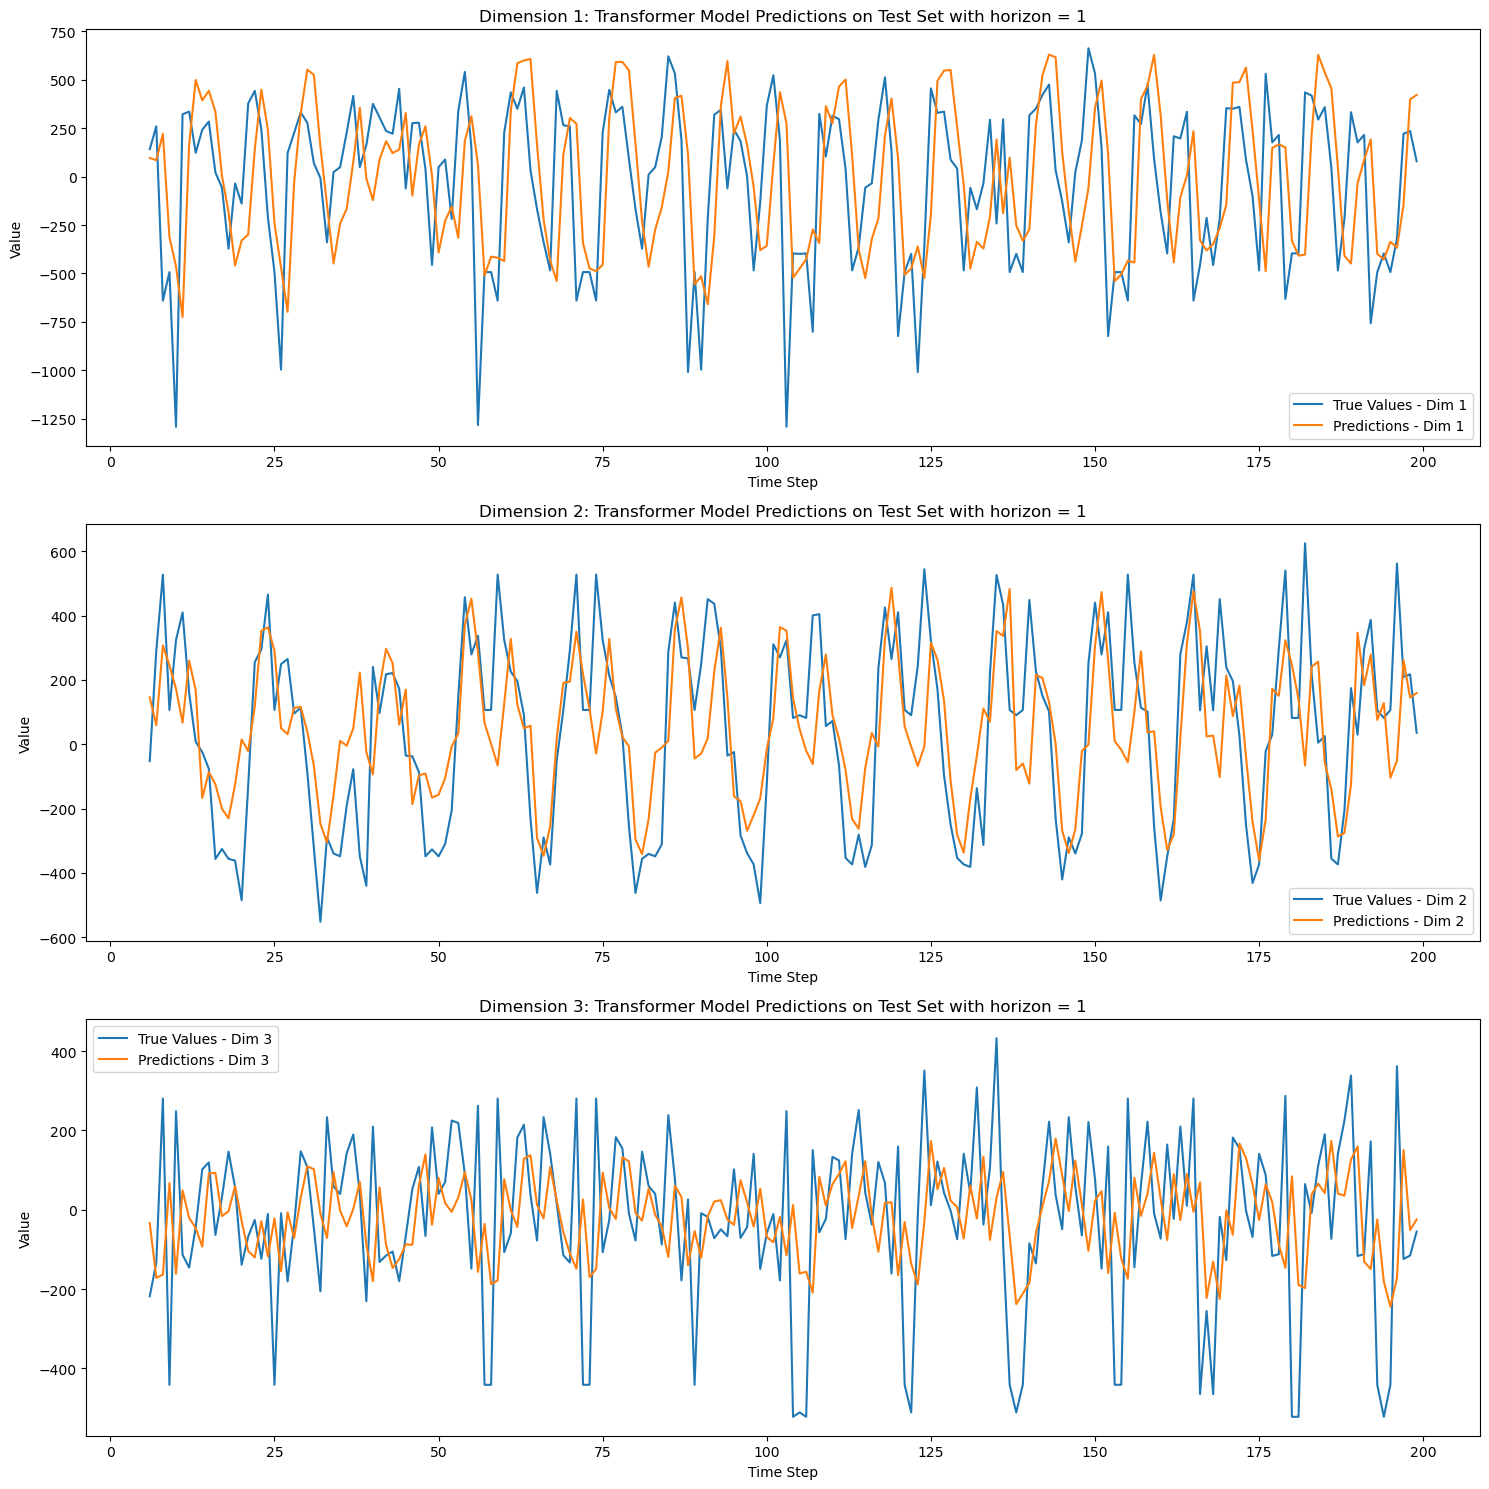

In [22]:
# Plot test predictions for each dimension - again, extract that as a function
plt.figure(figsize=(15, 5 * n_features))
for i in range(n_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(test_indices, test_targets_rescaled[:, i], label=f"True Values - Dim {i+1}")
    plt.plot(test_indices, test_predictions_rescaled[:, i], label=f"Predictions - Dim {i+1}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.title(f"Dimension {i+1}: Transformer Model Predictions on Test Set with horizon = {horizon}")
    plt.legend()
plt.tight_layout()
plt.show()

In [23]:
# Calculate overall metrics across all dimensions
overall_mse = np.mean((test_predictions_rescaled - test_targets_rescaled) ** 2)
overall_rmse = np.sqrt(overall_mse)
overall_mae = np.mean(np.abs(test_predictions_rescaled - test_targets_rescaled))

print(f"Overall performance metrics for horizon = {horizon}:")
print(f"Test MSE: {overall_mse:.4f}, RMSE: {overall_rmse:.4f}, MAE: {overall_mae:.4f}")

Overall performance metrics for horizon = 1:
Test MSE: 97464.1562, RMSE: 312.1925, MAE: 231.4487


In [24]:
# Auxiliary function - not sure yet about it but keeping that here in case...

import json


def load_model(model_path, config_path, device):
    """Load a trained model and its configuration"""
    # Load configuration
    with open(config_path, "r") as f:
        config = json.load(f)

    # Initialize model
    model = tf.init_model(config)

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # Set model to evaluation mode

    return model, config


horizon_dir = os.path.join(model_output_dir, f"horizon_{horizon}")